In [151]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os


In [152]:
path = 'plant_segmentation/dataset/arabidopsis/*/*'
imagepath = 'plant_segmentation/dataset/arabidopsis/images/*'
maskspath = 'plant_segmentation/dataset/arabidopsis/masks/'

In [153]:
def get_mask(image):
     return tf.strings.split(image,os.path.sep)[-1]

def process_image_with_mask(file_path):
      img = tf.io.read_file(file_path)
      img = tf.image.decode_png(img)
      mask = maskspath + get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      return img,mask

def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   img = tf.image.resize(img, (128, 128), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   print(img.shape)
   return img

def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def rotation1(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

def rotation2(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.int16) 
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath,shuffle = False)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(rotation1)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation2)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [154]:
dataset = tf_dataset(imagepath,learning = True)
dataset

<MapDataset element_spec=(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, None), dtype=tf.int16, name=None))>

In [155]:
len(dataset)

64

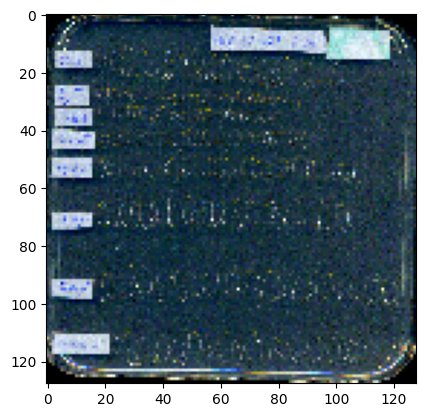

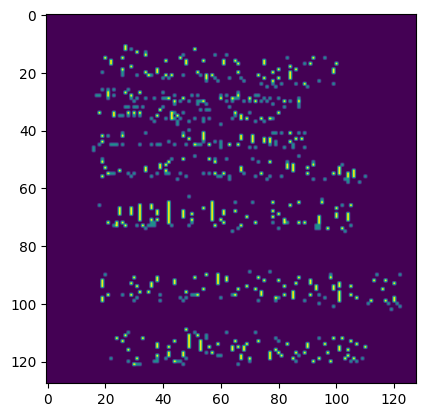

In [156]:
for image,mask in dataset.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))

In [157]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [158]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [173]:
unet_model = build_unet_model()

In [174]:
unet_model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy",run_eagerly=True)

In [175]:
model_history = unet_model.fit(dataset.batch(16).repeat(),
                              epochs=32,
                              steps_per_epoch=1)

Epoch 1/32


1/1 [==============================] - 2s 2s/step - loss: 1.0447 - accuracy: 0.2945
Epoch 2/32
1/1 [==============================] - 1s 1s/step - loss: 0.3586 - accuracy: 0.9518
Epoch 3/32
1/1 [==============================] - 2s 2s/step - loss: 0.4091 - accuracy: 0.9525
Epoch 4/32
1/1 [==============================] - 1s 858ms/step - loss: 0.2764 - accuracy: 0.9525
Epoch 5/32
1/1 [==============================] - 1s 1s/step - loss: 0.2752 - accuracy: 0.9525
Epoch 6/32
1/1 [==============================] - 1s 1s/step - loss: 0.4661 - accuracy: 0.9525
Epoch 7/32
1/1 [==============================] - 1s 1s/step - loss: 0.2868 - accuracy: 0.9525
Epoch 8/32
1/1 [==============================] - 1s 920ms/step - loss: 0.2634 - accuracy: 0.9525
Epoch 9/32
1/1 [==============================] - 1s 1s/step - loss: 0.2514 - accuracy: 0.9525
Epoch 10/32
1/1 [==============================] - 1s 1s/step - loss: 0.2491 - accuracy: 0.9525
Epoch 11/32
1/1 [==============================] - 1s 

In [179]:
test = tf_dataset('cropped/AAE_0196.png',learning=False)
test

(128, 128, None)


<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None)>

In [180]:
pred_mask = unet_model.predict(test)

1/1 [==============================] - 0s 257ms/step


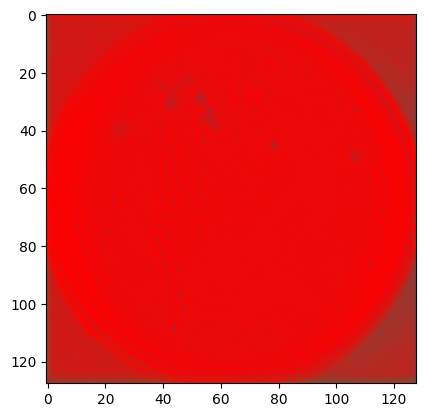

In [181]:
plt.imshow(pred_mask[0,:,:,:])